# Detekce anomálií v datech o znečištění ovzduší

> Chytré lampy na Karlínském náměstí poskytují data o znečištění ovzduší polétavým prachem PM10. V této práci v nich detekuji anomálie pomocí algoritmů strojového učení pro predikci časových řad.

Otevřená data přináší velký prostor pro aplikaci metod strojového učení a pro zlepšení kvality života nebo přírodního prostředí. Tato práce se zabývá detekcí anomálií v datech o polétavém prachu z chytrých lamp, které jsou poskytovány hlavním městem Praha jako otevřená data.

Pevné částice (nebo polétavý prach, anglicky particulate matter, PM) jsou tuhé nebo kapalné částice v ovzduší o velikosti v rozsahu 1 nm až 100 µm. Data použitá v tomto projektu obsahují PM<sub>10</sub> (částice menší než 10 µm) a PM<sub>2,5</sub> (částice menší než 2,5 µm). PM2,5 je tedy podmnožina měření PM<sub>10</sub>, a proto budu hledat anomálie pouze v PM<sub>10</sub>.

V této práci chci prozkoumat přístup k měření pomocí predikce časové řady následovanou prahovnáním. Chci, aby se zvolený model naučil pravidelnosti v datech a pokud se stane něco neočekávaného, tak to pomocí prahování dokáži odhalit. Jako algoritmy strojového učení jsem vyzkoušel lineární regresi a LSTM rekurentní neuronovou síť. Ukázalo se, že lineární regrese pro tento problém postačuje, protože je schopna časovou řadu koncentrace PM<sub>10</sub> nejlépe předpovídat.

Tato zpráva je rozdělena do několika částí, které se postupně zabývají explorací dat, předzpracovním, metrikami, selekcí příznaků, porovnáním modelů a testováním výsledného algoritmu.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pandas.plotting import scatter_matrix
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


from lampy import data
from lampy import metrics
from lampy import plot
from lampy.lstm import LSTM

## Explorace

Pražská datová platforma Golemio poskytuje data z pilotního provozu Senzorické sítě veřejného osvětlení, v rámci kterého bylo nainstalováno 92 chytrých pouličních LED lamp v blízkosti Karlínského náměstí na Praze 8. Některé z těchto lamp mají senzory pro měření a sběr dat o hluku, prašnosti a množství dalších polutantů.

### Datové zdroje

V katalogu datové platformy Golemio jsou k dispozici dva datové CSV soubory: jeden za 2. pololetí roku 2018 a druhý za zatím uplynulou část 1. pololetí roku 2019. Data z roku 2018 obsahují celkem 473529 záznamů. Z toho jsou dostupné odečty PM<sub>10</sub> pouze v 129807 případech. V souboru za roku 2019 je celkem 226672 záznamů a z toho 62518 měření PM<sub>10</sub>.

In [2]:
data_file_2018 = 'data/636f6a2e-3a48-4801-afce-05c864adc60e-lampy_2019.csv'
data_2018 = pd.read_csv(data_file_2018, index_col='sid', sep=';', parse_dates=['starttimestamp'])
data_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473529 entries, 24a5mhj5yiqqhmtxzvsztbwxoduhdzyd to y7e4onsytkb3ydonflz5kcbcigkh5ulo
Data columns (total 8 columns):
starttimestamp              473529 non-null datetime64[ns, UTC]
geocoordinates_latitude     473505 non-null float64
geocoordinates_longitude    473505 non-null float64
o3                          407537 non-null float64
pm2p5                       129807 non-null float64
no2                         407537 non-null float64
so2                         407537 non-null float64
pm10                        129807 non-null float64
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 32.5+ MB


In [3]:
data_file_2019 = 'data/2e6bbd16-8d1c-4efa-b0f0-06a74f40d8d3-lampysensory-2019-1pololeti.csv'
data_2019 = pd.read_csv(data_file_2019, index_col='sid', parse_dates=['starttimestamp'])
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226672 entries, 6aivodbkkk3xlwbjlkerclrnk4gtfy3x to oowrrh4zfxs66zdreivyrri2ribhexgc
Data columns (total 8 columns):
starttimestamp              226672 non-null datetime64[ns, UTC]
geocoordinates_latitude     226672 non-null float64
geocoordinates_longitude    226672 non-null float64
o3                          196871 non-null float64
pm2p5                       62518 non-null float64
no2                         196871 non-null float64
so2                         196871 non-null float64
pm10                        62518 non-null float64
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 15.6+ MB


Každý záznam se skládá z následujích atributů:

- `sid` (string): identifikátor stanice;
- `starttimestamp` (datetime): datum a čas měření,
- `o3` (integer with precision): atribut O<sub>3</sub> (ozon, ppb),
- `no2` (integer with precision): atribut NO<sub>2</sub> (oxid dusičitý, ppb),
- `so2` (integer with precision): atribut SO<sub>2</sub> (oxid siřičitý, ppb),
- `pm10` (integer with precision): atribut jemné částice PM<sub>10</sub> (µg m<sup>-3</sup>),
- `pm2p5` (integer with precision): atribut jemné částice PM<sub>2,5</sub> (µg m<sup>-3</sup>),
- `geocoordinates_latitude` (integer with precision): zeměpisná šířka stanice,
- `geocoordinates_longitude` (integer with precision): zeměpisná délka stanice,

kde ppb znamená [parts per bilion](https://en.wikipedia.org/wiki/Parts-per_notation). Datová sada by měla obsahovat odečty z 43 senzorů, které jsou rozmístěny na vybraných lampách, ale ve skutečnosti jsou k dispozici data pouze z 22 senzorů.

In [4]:
sids = data_2018.index.unique()
print('počet senzorů:', len(sids))

počet senzorů: 22


Ze 22 senzorů měří podle dostupných dat polétavý prach PM<sub>10</sub> pouze 6 senzorů z nich nejvíce měření má stanice s identifikátorem: `y7e4onsytkb3ydonflz5kcbcigkh5ulo`.

In [5]:
target = 'pm10'
value_counts = data_2018[target].dropna().index.value_counts()
sid = value_counts.index[0]
value_counts

y7e4onsytkb3ydonflz5kcbcigkh5ulo    32872
heql54pdiq6xb6j74qdpnlovm77jaify    24548
6czebgzn24hwd3vpklvuphomcfcwpqgx    24100
xct4lqv4q3ht3a7peubhfnyyhbsnno7g    17447
bxjhuifodo6nf7bnstd55g3mzw6wfv7c    17078
gdyaoaed7gnarg6kqk2o6bmsjrw6wlk5    13762
Name: sid, dtype: int64

### Trénovací a testovací data

Vezmeme-li si pouze data z této lampy a ponecháme si atributy `o3`, `pm2p5`, `no2`, `so2` a `pm10`, tak dostaneme data dimenze 5, kterí obsahují 32872 záznamů v roce 2018 a 12709 záznamů v roce 2019, a to je dohromady 45581 záznamů za oba roky. Protože pracujeme s časovou řadou jako index zachováme datum a čas měření tedy `starttimestamp`.

Dále se přímo nabízí rozdělit data na trénovací a testovací množinu podle roku měření tj. podle souborů. Takové rozdělení má 72,1% dat v trénovací množině a 27,9% dat v množině testovací.

In [6]:
features = ['o3', 'pm2p5', 'no2', 'so2', 'pm10']

In [7]:
train_data = data_2018.loc[sid].set_index('starttimestamp')[features].sort_index()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32872 entries, 2018-07-05 11:52:18+00:00 to 2018-12-31 23:53:11+00:00
Data columns (total 5 columns):
o3       32872 non-null float64
pm2p5    32872 non-null float64
no2      32872 non-null float64
so2      32872 non-null float64
pm10     32872 non-null float64
dtypes: float64(5)
memory usage: 1.5 MB


In [8]:
test_data = data_2019.loc[sid].set_index('starttimestamp')[features].sort_index()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12709 entries, 2019-01-01 00:03:11+00:00 to 2019-04-04 15:23:07+00:00
Data columns (total 5 columns):
o3       12709 non-null float64
pm2p5    12709 non-null float64
no2      12709 non-null float64
so2      12709 non-null float64
pm10     12709 non-null float64
dtypes: float64(5)
memory usage: 595.7 KB


In [9]:
n_train = train_data.shape[0]
n_test = test_data.shape[0]
n_data = n_train + n_test
print('celkem záznamů:', n_data)
print('trénovacích záznamů: {} ({:.1f}%)'.format(n_train, 100 * n_train / n_data))
print('testovacích záznamů: {} ({:.1f}%)'.format(n_test, 100 * n_test / n_data))

celkem záznamů: 45581
trénovacích záznamů: 32872 (72.1%)
testovacích záznamů: 12709 (27.9%)


### Vizualizace

Základní vizualizace časové řady ukazuje, že v datech o polétavém prachu opravdu nějaké anomálie jsou. Dále je vidět, že data na první pohled neobsahují žádné známky sezóního chování.

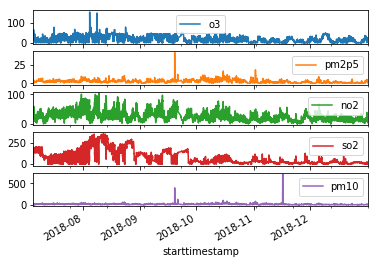

In [10]:
train_data.plot(subplots=True)
plt.savefig('img/data_preview.svg')

Boxplot ukazuje že z hlediska absolutní velikosti hodnoty PM<sub>10</sub> mnoho bodů vybočuje od průměru 14.093698, který má relativně malou standarní odchylku 18.931824. Samozřejmě všechny tyto body nemusí být anomálie, protože naše detekce je časově závislá a záleží na předchozích měřeních.

count    32872.000000
mean        14.093698
std         18.931824
min          1.000000
25%          6.000000
50%         11.430000
75%         18.650000
max        718.900000
Name: pm10, dtype: float64

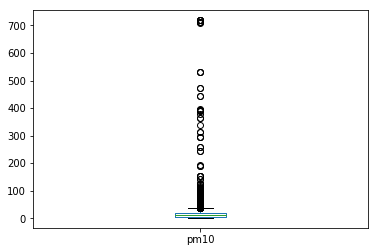

In [11]:
train_data['pm10'].plot.box()
plt.savefig('img/boxplot.svg')
train_data['pm10'].describe()

Jistou lineární závislost naznačuje tak zvaný *lag plot*, který zobrazuje závíslost měření na měřením předchozím, body se totiž shormaždují na diagonále. I zde je vidět zhruba 6 anomálních měření, která leží mimo diagonálu.

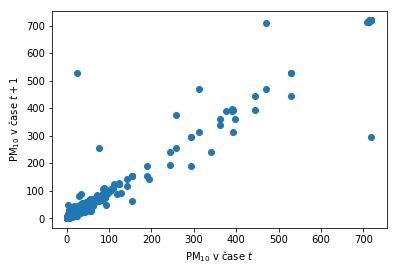

In [12]:
ax = lag_plot(train_data['pm10'])
ax.set_xlabel('PM$_{10}$ v čase $t$')
ax.set_ylabel('PM$_{10}$ v čase $t + 1$')
plt.savefig('img/lag_plot.svg')

Poslední vizualizační pomůckou, kterou prozkoumáváme data je korelační graf. Zajímá nás především korelace příznaku `pm10` s ostaními. Za povšimnutí stojí, že anomálie PM<sub>10</sub> se vyskutují pouze pokud je nízká hladina SO<sub>2</sub> a O<sub>3</sub>.

Každopádně tento vztah zřejmě není lineární, protože korelační koeficient je v obou případech blízký nule (0.028117 resp. -0.067698) v porovnání s největším korelační koeficient, který má s příznakem `pm2p5`, a to 0.530632. Z korelačního grafu PM<sub>10</sub> a PM<sub>2,5</sub> je ale vidět, že nekteré anomáli nastávají jak při zvyšené hladině PM<sub>2,5</sub> tak při jejím normálním stavu.

,o3,pm2p5,no2,so2,pm10
o3,1.000000,-0.056971,-0.034901,0.344683,-0.067698
pm2p5,-0.056971,1.000000,0.501517,0.017095,0.530632
no2,-0.034901,0.501517,1.000000,0.090230,0.320133
so2,0.344683,0.017095,0.090230,1.000000,0.028117
pm10,-0.067698,0.530632,0.320133,0.028117,1.000000


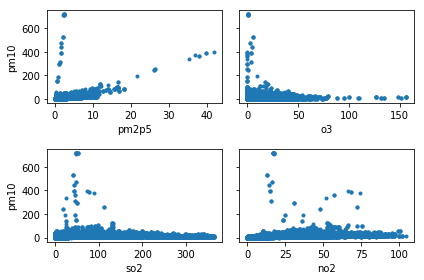

In [14]:
fig, axs = plt.subplots(2, 2, sharey=True)
axs[0, 0].set_ylabel('pm10')
axs[1, 0].set_ylabel('pm10')
for ax, col in zip(axs.ravel(), ['pm2p5', 'o3', 'so2', 'no2']):
    ax.plot(train_data[col], train_data['pm10'], '.')
    ax.set_xlabel(col)
fig.tight_layout()
plt.savefig('img/scatter_plot.svg')
train_data.corr()

### Rozdíl časů odečtů

Podle specifikace je vyčítací frekvence 15 minut z brány do platformy. Naše data takovéto pravidelné intervaly neobsahují. Průměrně je dostupné nové měření asi každých 7 minut a 52 sekund se standarní odchylkou zhruba 18 minut a 20 sekund.

Zřejmé výpadky ale mohou systém odstavit i na delší dobu. V našich datech je nejdelší prodleva přes 1 den a 15 hodin.

In [15]:
time_delta = pd.Series(train_data.index[1:] - train_data.index[:-1])
time_delta_mean = time_delta.mean()
time_delta_std = time_delta.std()
time_delta_mean, time_delta_std

(Timedelta('0 days 00:07:51.809588'), Timedelta('0 days 00:18:20.667901'))

In [16]:
time_delta.max()

Timedelta('1 days 15:36:51')

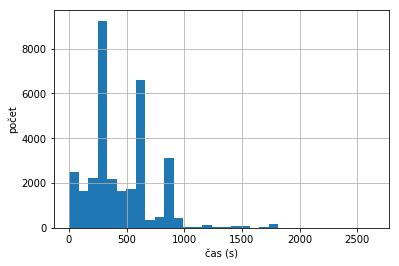

In [17]:
ax = time_delta[time_delta < time_delta_mean + 2 * time_delta_std].dt.total_seconds().hist(bins=32)
ax.set_xlabel('čas (s)')
ax.set_ylabel('počet')
plt.savefig('img/cas_odectu.svg')

### Log–log plot

Poslední vizualizační pomůckou, která nám pomůže nahlédnou do dat z hlediska jejich absolutní velikosti je tzv. log–log graf. Především v jeho pravé dolní části je vidět, že data obsahují něktré abnormálně velké hodnoty a bude úkolem námi naučených klasifikátorů tyto hodnoty najít i vzhledem k časové závislosti na bodech předchozích.

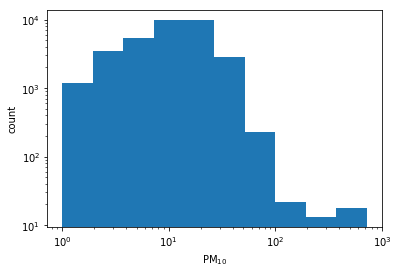

In [18]:
pm10 = train_data['pm10'].values
ax = plt.axes(xlabel='PM$_{10}$', ylabel='count')
bins = np.logspace(np.log10(pm10.min()), np.log10(pm10.max()), num=11)
ax.hist(pm10, bins, log=True)
ax.set_xscale('log')
plt.savefig('img/log-log_plot.svg')

## Předzpracování

Původní data tedy nejsou samplovány v rovnoměrných intervalech, a proto je v rámci předzpracování přesamplujeme na každých 15 minut, což je vyčítací frekvence z platformy a k doplnění chybějících hodnot použijeme metodu *fill forward*, která doplní vždy předchozí hodnotu.

Data musí přetransformovat do podoby vhodné pro předpovídání časových řad, abychom potom mohli detekovat anomálie. To znamená že z měření v čase $t$ se budeme snažit předpovědět hodnotu `pm10` v čase $t + 1$.

Poté data rozdělíme na trénovací a validační množinu. Validační množina nám poslouží k výběru modelu a jeho hyperparametrů. Konzervativně jsem se rozhodnul, že data rozdělím na půlky tak, aby odhad byl co nejpřesnější. 

Nakonec aby různé příznaky byly zhruba stejných rozsahů použijeme standadrní škálování, takže každý příznak má trénovací množiny bude mít nulový průměr a jenotkovou standardní odchylku. Takto předzpracovaná data nám umožní i správnou selekci příznaků pomocí linearní regrese s L1 regularizací.

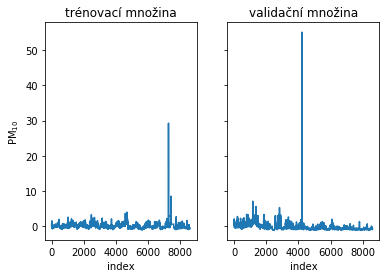

In [19]:
resampled_train_data = data.resample_data(train_data, period='15T')
X, y = data.create_dataset(resampled_train_data)

X_tr_raw, X_val_raw, y_tr_raw, y_val_raw = data.train_validation_split(X, y)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_tr_all = X_scaler.fit_transform(X_tr_raw)
y_tr = y_scaler.fit_transform(y_tr_raw)

X_val_all = X_scaler.transform(X_val_raw)
y_val = y_scaler.transform(y_val_raw)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(y_tr)
ax1.set_ylabel('PM$_{10}$')
ax1.set_title('trénovací množina')
ax1.set_xlabel('index')
ax2.plot(y_val)
ax2.set_title('validační množina')
ax2.set_xlabel('index')
plt.savefig('img/train_validation_split.svg')

## Selekce příznaků

Selekce podmnožiny příznaků může být důležitá například pro snížení komunikační zátěže. Vhodné příznaky pro linearní modely můžeme vybrat napříkad pomocí linearní regrese s L1 regularizací (Lasso). Ta totiž koeficienty u nevhodný příznaků drží blízko nule.

Z výše zmíněných důvodů jsem zkusil natrénovat Lasso pro 23 různých hodnot regularizačního parametru na logaritmické škále mezi 10<sup>-10</sup> a 10<sup>1</sup>. Výsledné grafy jasně ukazují, že důležitý je pouze příznak `pm10`, protože ostatní jsou blízké nule, pokud jekvadratická odmocnina ze střední kvadratická odchylka nízká. Pro testované lineární modely stačí tedy uvažovat pouze tento příznak.

,RMSE,koeficient o3,koeficient pm2p5,koeficient no2,koeficient so2,koeficient pm10
alpha,,,,,,
1.000000e-10,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-10,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-09,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-09,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-08,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-08,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
1.000000e-07,0.638710,-0.016698,0.001962,0.019413,0.011029,0.947370
3.162278e-07,0.638710,-0.016697,0.001962,0.019412,0.011029,0.947370
1.000000e-06,0.638710,-0.016697,0.001963,0.019412,0.011028,0.947369


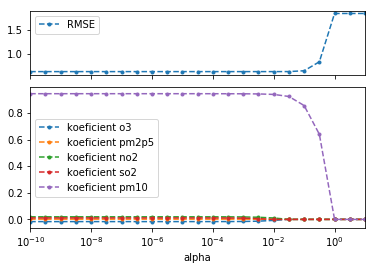

In [20]:
n_features = X_tr_all.shape[1]
columns = ['RMSE'] + ['koeficient ' + feature for feature in features]

n_alphas = 23
alphas = np.logspace(-10, 1, n_alphas)
lasso_stats = pd.DataFrame(index=alphas, columns=columns, dtype=np.float)
lasso_stats.index.name = 'alpha'

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_tr_all, y_tr)

    y_pred = lasso.predict(X_val_all)
    
    lasso_rmse = metrics.rmse(y_val, y_pred)
    lasso_stats.loc[alpha] = (lasso_rmse, *lasso.coef_)

fig = plt.figure()
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1:, :])
lasso_stats.plot(ax=ax1, y='RMSE', logx=True, style='.--')
ax1.set_xlabel('')
ax1.set_xticklabels([])
lasso_stats.plot(ax=ax2, y=columns[1:], logx=True, style='.--')
plt.savefig('img/feature_selection.svg')
lasso_stats

In [21]:
target_index = np.where(train_data.columns == 'pm10')[0][0]
X_tr = X_scaler.fit_transform(X_tr_raw[:, [target_index]])
X_val = X_scaler.transform(X_val_raw[:, [target_index]])

## Porovnání modelů

Problém je definovám tak, že předpovíme pomocí nějakého algoritmu strojové učení následují hodnotu, která by měla následovat po jich zaznamenaných měření. Předpovězenou hodnotu potom porovnáme s naměřenou hodnotou a pokud se tyto hodnoty nepřirozeně liší, tak měření označíme jako anomálii.

Jako vhodné algoritmy jsem zvolil tři základní:

- základní model, který předpokládá že následující hodnota měření bude stejná jako přechozí,
- lineární regresní model a
- rekurentní neuronovou síť (konkrétně dnes nejpopulárnější Long Short-Term Memory).

Abych mohl modely mezi sebou porovnávat je potřeba zvolit nějakou metriku. Pro regresní problémy je nejpřirozenější odmocnina ze střední kvadratické chyby:

$$\mathrm{RMSE} = \sqrt{\frac{1}{N} \sum^{N}_{i = 1}(\hat{y_i} - y_i)^2},$$

kde $N$ je počet měření, $\hat{y_i}$ je predikce modelu a $y_i$ je skutečně naměřená hodnota.

### Základní model

Základní model nám poskytny odrazový můstek, ke kterému budeme moci vztahovat výsledky ostatních modelů. Navíc je jednoduchý na implementaci a dosahuje výsledku vypsaného níže.

In [22]:
y_pred = X_val
baseline_rmse = metrics.rmse(y_val, y_pred)
print('RMSE základního modelu:', baseline_rmse)

RMSE základního modelu: 0.6492021924513823


### Linearní regrese

Druhým modelem je linearní regrese a nyní už bez regularizace, protože nám zůstal pouze jeden příznak. Pokud necháme tento model předpovídat pouze z bezprostředně předcházející hodnoty dostaneme RMSE viz níže.

In [23]:
linear_predictor = linear_model.LinearRegression()
linear_predictor.fit(X_tr, y_tr)

y_pred = linear_predictor.predict(X_val)

linear_rmse = metrics.rmse(y_val, y_pred)
print('RMSE lineární regrese:', linear_rmse)

RMSE lineární regrese: 0.6401653966120437


Můžeme ale také nechat linearní regresi předpovídat z hodnot větší historie. Graf níže ukazuje výsledek pro velikosti hisotrie 1 až 100. Jako nejlepší se ukazuje velikost historie hodnoty 2, kde je RMSE rovna 0.63797. Následně se RMSE zhorší a poté konverguje k hodnotě zhruba 0,71.

,RMSE
okno,
2,0.63797


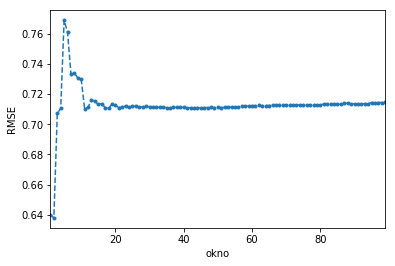

In [24]:
windows = list(range(1, 100))
linear_stats = pd.DataFrame(index=windows, columns=['RMSE'],
                            dtype=np.float)
linear_stats.index.name = 'okno'

for window in windows:
    X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, window)
    X_val_trans, y_val_trans = data.transform_dataset(X_val, y_val, window)

    linear = linear_model.LinearRegression()
    linear.fit(X_tr_trans, y_tr_trans)

    y_pred = linear.predict(X_val_trans)
    linear_stats.loc[window] = metrics.rmse(y_val_trans, y_pred)

ax = linear_stats.plot(style='.--', legend=False)
ax.set_ylabel('RMSE')
plt.savefig('img/linear_regresion_window.svg')
best_window = linear_stats['RMSE'].idxmin()
best_linear_rmse = linear_stats.loc[best_window, 'RMSE']
linear_stats.loc[[best_window]]

### Long Short-Term Memory (LSTM) rekurentní neuronová síť

Poslední a nejkomplexnější model je [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/), který dokáže zachytit i nelineární vztahy v datech, a proto vstupu tohoto modelu všechny příznaky.

Jako architekturu jsou zvolil jednovrstvout rekuretní síť s velikostí skrytého stavu 64. Výstupem ale musí být pouze jedno číslo které predikuje měření PM<sub>10</sub>. Proto je na vlastní buňce LSTM ještě linearní vrstva, která produkuje onu jednu výstupní hodnotu.

Co se týče trénování, LSTM jsem trénoval na sekvencích délky 100 a celkem 50 epoch. Výsledné RMSE na validační setu viz níže.

epoch: 1 train loss: 0.6449523878215152 validation loss: 2.534697437906221
epoch: 2 train loss: 0.5115504897045522 validation loss: 2.3770948036356776
epoch: 3 train loss: 0.4379483342672321 validation loss: 2.258110365163649
epoch: 4 train loss: 0.38332853845676845 validation loss: 2.168988382805246
epoch: 5 train loss: 0.3419611975306335 validation loss: 2.0906308031569174
epoch: 6 train loss: 0.3105153594710348 validation loss: 2.008346345099234
epoch: 7 train loss: 0.2855221894052211 validation loss: 1.93930305898909
epoch: 8 train loss: 0.2661464778713458 validation loss: 1.8777844952341574
epoch: 9 train loss: 0.2508727604275184 validation loss: 1.8397984128365832
epoch: 10 train loss: 0.23999728943776388 validation loss: 1.804845953386142
epoch: 11 train loss: 0.2263199554786874 validation loss: 1.748516794698816
epoch: 12 train loss: 0.21803206919421655 validation loss: 1.7354634319507312
epoch: 13 train loss: 0.20562415237487708 validation loss: 1.6833086925850163
epoch: 14 tr

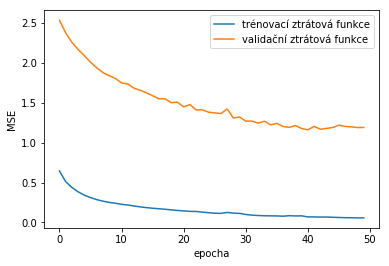

In [25]:
lstm = LSTM(input_size=5, hidden_size=64, output_size=1)
lstm_stats = lstm.train(X_tr_all, y_tr, X_val_all, y_val,
                        n_epochs=50, seq_len=100)

ax = plt.axes()
ax.plot(lstm_stats['tr_losses'], label='trénovací ztrátová funkce')
ax.plot(lstm_stats['val_losses'], label='validační ztrátová funkce')
ax.set_xlabel('epocha')
ax.set_ylabel('MSE')
ax.legend()
plt.savefig('img/losses.svg')

y_pred = lstm.predict(X_val_all)
lstm_rmse = metrics.rmse(y_val, y_pred)
print('RMSE LSTM:', lstm_rmse)

### Výsledky

Níže jsou porovnány RMSE všech čtyř různých přístupů k předpovědi časové řady na validačním setu a jako nejlepší možnost se tedy jeví lineární regrese.

In [26]:
print('RMSE základního modelu:', baseline_rmse)
print('RMSE lineární regrese:', linear_rmse)
print('RMSE lineární regrese s oknem:', best_linear_rmse)
print('RMSE LSTM:', lstm_rmse)

RMSE základního modelu: 0.6492021924513823
RMSE lineární regrese: 0.6401653966120437
RMSE lineární regrese s oknem: 0.6379701112790592
RMSE LSTM: 1.091153725105511


## Detekce anomálií

Nyní po výběru vhodného prediktivního modelu mohu detekovat anomálie postupem stejným jako v článku Time Series Anomaly Detection. Postup je následující:

1. lineární regresní model s oknem 2 predikuje další měření PM10,
2. predikovanou hodnotu porovnám se skutečně naměřenou hodnotou (vypočítám rozdíl v absolutní hodnotě, $\mid\hat{y}- y\mid$,
3. pomocí prahování určím, zda se jedná o anomálii.

Histogram absolutní hodnoty rozdílu predikce $\hat{y}$ 
a skutečné hodnoty $y$ je na obrázku níže. Většina hodnot je malé velikosti, protože pochází z předvídatelné distribuce, kterou dokáže lineární regrese zachytit.

Teď bych potřeboval doménového experta, který by dokázal určit, které rozdíly jsou abnormální a které přirozené. Takový expert ale není k dispozici, a tak zvolím jako hodnotu pro pahování hodnotu okraje prvního binu z histogramu výše: 3,9617.

Takto zvolený práh odhalil ve validačních datech celkem 9 anomálií, které jsou zobrazeny v obrázku níže.

práh: 3.9616825935216116
detekováno anomálií: 9


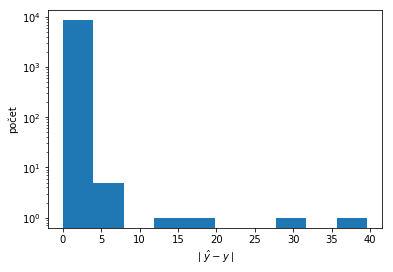

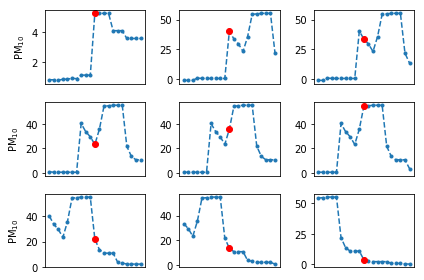

In [27]:
linear = linear_model.LinearRegression()
X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, best_window)
X_val_trans, y_val_trans = data.transform_dataset(X_val, y_val, best_window)
linear.fit(X_tr_trans, y_tr_trans)

y_pred = linear.predict(X_val_trans)
y_delta = np.abs(y_val_trans - y_pred)

plot.plot_delta_hist(y_delta)
plt.savefig('img/delta_histogram.svg')

_, bins = np.histogram(y_delta)
threshold = bins[1]
print('práh:', threshold)

anomalies = y_delta > threshold
print('detekováno anomálií:', anomalies.sum())
plot.plot_anomalies(anomalies, y_val_trans)
plt.savefig('img/anomalies.svg')

## Testování

Postup pro detekci anomálii je vyvinutý a stačí jej otestovat na testovacích datech. Jak ukazuje graf níže, jsou tyto data daleko složitější a obsahují zřejmě daleko více anomálií. Pro trénování jsem použil všechna data z roku 2018, která předzpracuji stejně jako v předchozích pokusech a následně aplikuji postup popsaný v předchozí části.

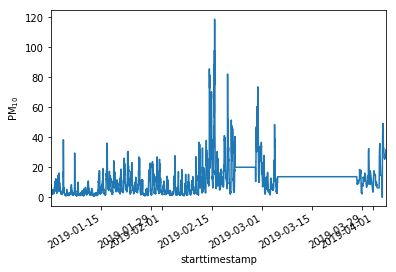

In [28]:
ax = test_data.plot(y='pm10', legend=False)
ax.set_ylabel('PM$_{10}$')
plt.savefig('img/test_data.svg')

Podle histogramu níže můj algoritmus opravdu správně detekoval daleko více anomálií než ve validačním setu (pro testovací množinu je hodnota prahu: 6,8293).

Pomocí stanoveného prahu jsem detekoval celkem 113 anomálií, které jsou zobrazené na grafu níže. Veškeré abnormálně vysoké špičky byly detekovány správně. Také je vidět, že některé špičky detekovány nebyly, to může být tím, že nárůst je tak pozvolný a za tak dlouhý časový okamžik, že se vlastně o anomálii nejedná, ale je to předpovídatelné chování.

Obrázek níže zobrazuje 9 náhodně vybraných anomálií z celkem 113 detekovaných.

práh: 6.8293040906529106
detekováno anomálií v testovacích datech: 113


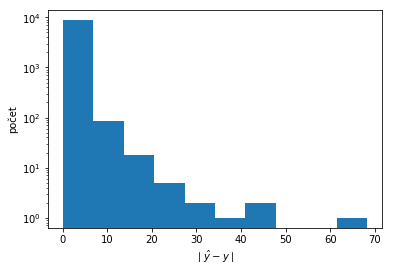

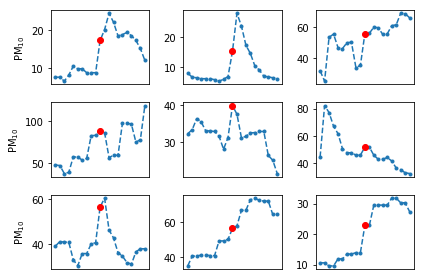

In [29]:
resampled_test_data = data.resample_data(test_data, period='15T')

X_tr = resampled_train_data[['pm10']].values[:-1]
y_tr = resampled_train_data[['pm10']].values[1:]
X_te = resampled_test_data[['pm10']].values[:-1]
y_te = resampled_test_data[['pm10']].values[1:]

linear = linear_model.LinearRegression()
X_tr_trans, y_tr_trans = data.transform_dataset(X_tr, y_tr, best_window)
X_te_trans, y_te_trans = data.transform_dataset(X_te, y_te, best_window)
linear.fit(X_tr_trans, y_tr_trans)

y_pred = linear.predict(X_te_trans)
y_delta = np.abs(y_te_trans - y_pred)

plot.plot_delta_hist(y_delta)
plt.savefig('img/test_delta_histogram.svg')

_, bins = np.histogram(y_delta)
threshold = bins[1]
print('práh:', threshold)

anomalies = y_delta > threshold
print('detekováno anomálií v testovacích datech:', anomalies.sum())

np.random.seed(16)
index = np.arange(anomalies.shape[0])[anomalies.ravel()]
random_index = np.random.choice(index, size=9, replace=False)
random_anomalies = np.zeros_like(anomalies)
random_anomalies[random_index] = True

plot.plot_anomalies(random_anomalies, y_te_trans)
plt.savefig('img/test_anomalies.svg')

/home/podondra/fit-cvut/lampy/venv/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


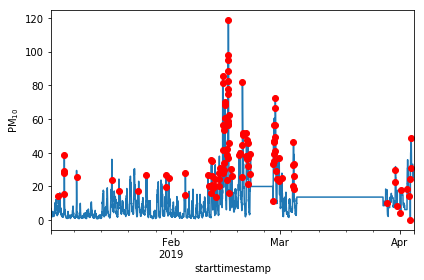

In [30]:
test_data_with_anomalies = resampled_test_data.iloc[best_window:].copy()
test_data_with_anomalies['anomaly'] = anomalies

ax = plt.axes()
test_data_with_anomalies.plot(ax=ax, y='pm10', legend=False)
test_data_with_anomalies[test_data_with_anomalies['anomaly']].plot(ax=ax, y='pm10', style='ro', legend=False)
ax.set_ylabel('PM$_{10}$')
plt.tight_layout()
plt.savefig('img/test_all_anomalies.svg')

## Závěr
V této práci jsem se zabýval detekcí anomálií v otevřených datech z chytrých lamp o polétavém prachu PM<sub>10</sub>. Jako nejlepší se ukázalo předpovídat časovou řadu pomocí lineární regrese (LSTM bylo horší), která na vstup dostane dvě poslední měření. Následně jsem předpověděnou hodnotu porovnal se skutečnou. Posledním krokem je prahování, které určí zda hodnoto je z hlediska modelu normální nebo ne.

Na testovacích datech se ukázalo, že tento postup je schopen detekovat většinu anomálií a také bere v úvahu momentální trendy v datech pokud trvají delší dobu a nestanou se náhlé změny.